In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Setup
nltk.download('vader_lexicon', quiet=True)
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")
os.makedirs('../visualizations', exist_ok=True)


In [3]:
def safe_load_csv(path):
    df = pd.read_csv(path, skipinitialspace=True, na_values=['', 'NA', 'null'])
    df.columns = df.columns.str.strip()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.strip()
    return df

# Load datasets
data = {}
paths = {
    'market_size': '../data/clean/market_size_quickcom_india.csv',
    'behavior': '../data/clean/E-commerce Customer Behavior - Sheet1.csv',
    'transactions': '../data/clean/Augmented_IndiaTransactMultiFacet2024.csv',
    'trends': '../data/clean/multiTimeline.csv',
    'financials': '../data/clean/swiggy_dunzo_financials.csv'
}

for name, path in paths.items():
    if os.path.exists(path):
        data[name] = safe_load_csv(path)
        # Convert numeric
        for col in data[name].columns:
            if col not in ['company', 'fiscal_year']:
                data[name][col] = pd.to_numeric(data[name][col], errors='coerce')
        print(f"Loaded {name}: {data[name].shape}")
    else:
        print(f"Missing: {path}")

# Assign
market_size = data.get('market_size')
behavior = data.get('behavior')
transactions = data.get('transactions')
trends = data.get('trends')

Loaded market_size: (11, 4)
Loaded behavior: (350, 11)
Loaded transactions: (10267, 21)
Loaded trends: (71, 1)
Loaded financials: (4, 8)



1/5: Market Growth


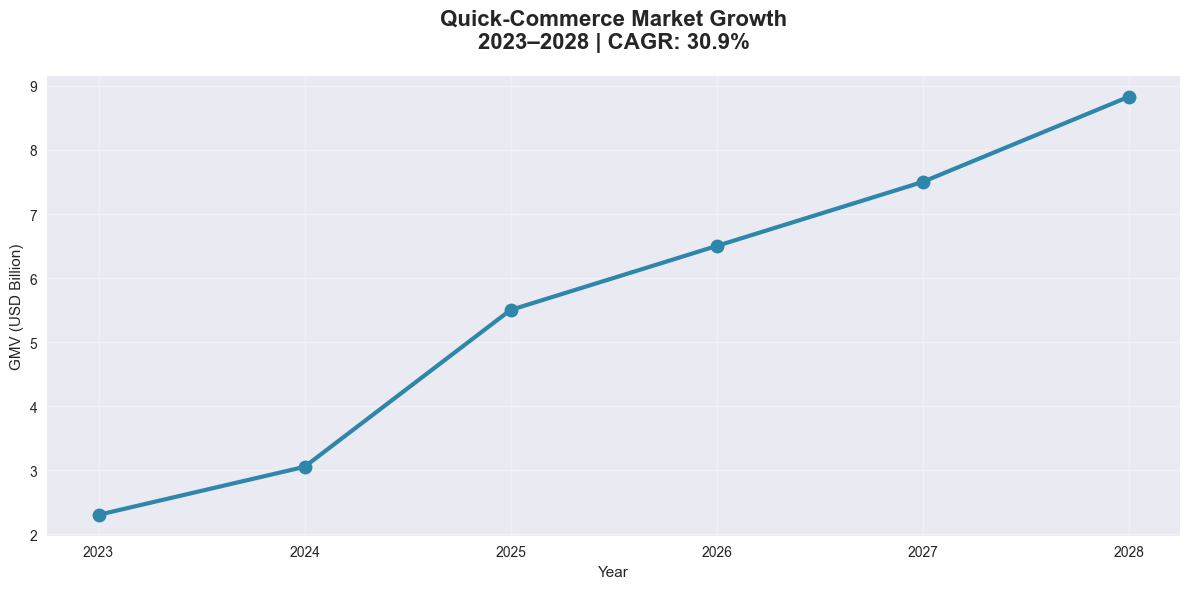

In [4]:
print("\n1/5: Market Growth")

m = market_size[(market_size['year'] >= 2023) & (market_size['year'] <= 2028)].copy()
cagr = ((m.iloc[-1]['gmv_usd_billion'] / m.iloc[0]['gmv_usd_billion']) ** (1/5) - 1) * 100

plt.figure(figsize=(12, 6))
plt.plot(m['year'], m['gmv_usd_billion'], 'o-', linewidth=3, markersize=10, color='#2E86AB')
plt.title(f'Quick-Commerce Market Growth\n2023–2028 | CAGR: {cagr:.1f}%', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year')
plt.ylabel('GMV (USD Billion)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/01_market_growth.png', dpi=300, bbox_inches='tight')
plt.show()


2/5: GMV Forecast


c:\Users\piyus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\piyus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\piyus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\piyus\AppData\Local\Programs\Python\Python313\Lib

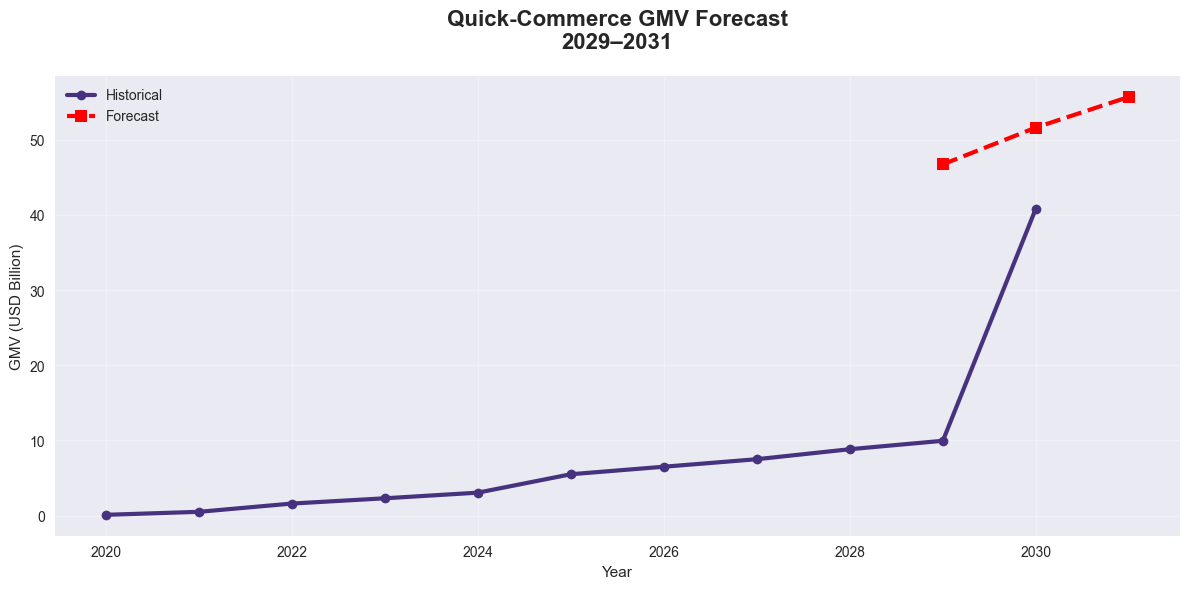

In [5]:
print("\n2/5: GMV Forecast")

series = market_size.set_index('year')['gmv_usd_billion'].dropna()
model = ARIMA(series, order=(1,1,1))
fitted = model.fit()
forecast = fitted.forecast(steps=3)
years = [2029, 2030, 2031]

plt.figure(figsize=(12, 6))
plt.plot(series.index, series.values, 'o-', label='Historical', linewidth=3)
plt.plot(years, forecast, 's--', label='Forecast', color='red', linewidth=3, markersize=8)
plt.title('Quick-Commerce GMV Forecast\n2029–2031', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year')
plt.ylabel('GMV (USD Billion)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/02_gmv_forecast.png', dpi=300, bbox_inches='tight')
plt.show()


3/5: Consumer Segmentation


C:\Users\piyus\AppData\Local\Temp\ipykernel_14964\2304390963.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=behavior[city_col].astype(str), y=behavior[income_col], palette='Set2')


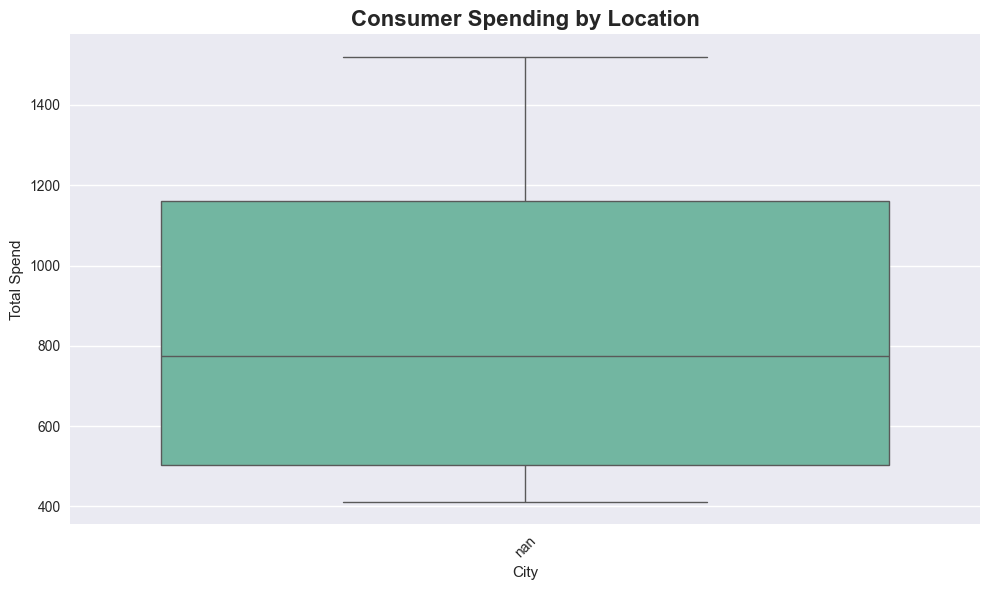

In [6]:
print("\n3/5: Consumer Segmentation")

city_cols = [c for c in behavior.columns if 'city' in c.lower() or 'tier' in c.lower()]
income_cols = [c for c in behavior.columns if any(x in c.lower() for x in ['income', 'spend', 'amount'])]

if city_cols and income_cols:
    city_col = city_cols[0]
    income_col = income_cols[0]
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=behavior[city_col].astype(str), y=behavior[income_col], palette='Set2')
    plt.title('Consumer Spending by Location', fontsize=16, fontweight='bold')
    plt.xlabel(city_col)
    plt.ylabel(income_col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('../visualizations/03_consumer_segment.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No city/income columns found. Skipping.")

In [7]:
print("\n4/5: City Clustering")

city_cols_t = [c for c in transactions.columns if 'city' in c.lower()]
spend_cols = [c for c in transactions.columns if any(x in c.lower() for x in ['amount', 'spend', 'value'])]

if city_cols_t and spend_cols:
    city_col = city_cols_t[0]
    spend_col = spend_cols[0]
    city_spend = transactions.groupby(city_col)[spend_col].mean().dropna().head(20)
    X = StandardScaler().fit_transform(city_spend.values.reshape(-1, 1))
    clusters = KMeans(n_clusters=3, random_state=42).fit_predict(X)

    plt.figure(figsize=(12, 7))
    plt.scatter(range(len(city_spend)), city_spend.values, c=clusters, cmap='plasma', s=150, edgecolors='black')
    plt.title('Top 20 Cities: Spending Clusters', fontsize=16, fontweight='bold')
    plt.xlabel('Cities')
    plt.ylabel('Avg Spend')
    plt.xticks(range(len(city_spend)), city_spend.index, rotation=90)
    plt.colorbar(label='Cluster')
    plt.tight_layout()
    plt.savefig('../visualizations/04_city_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No city/spend data. Skipping.")


4/5: City Clustering
No city/spend data. Skipping.



5/5: Sentiment Word Cloud


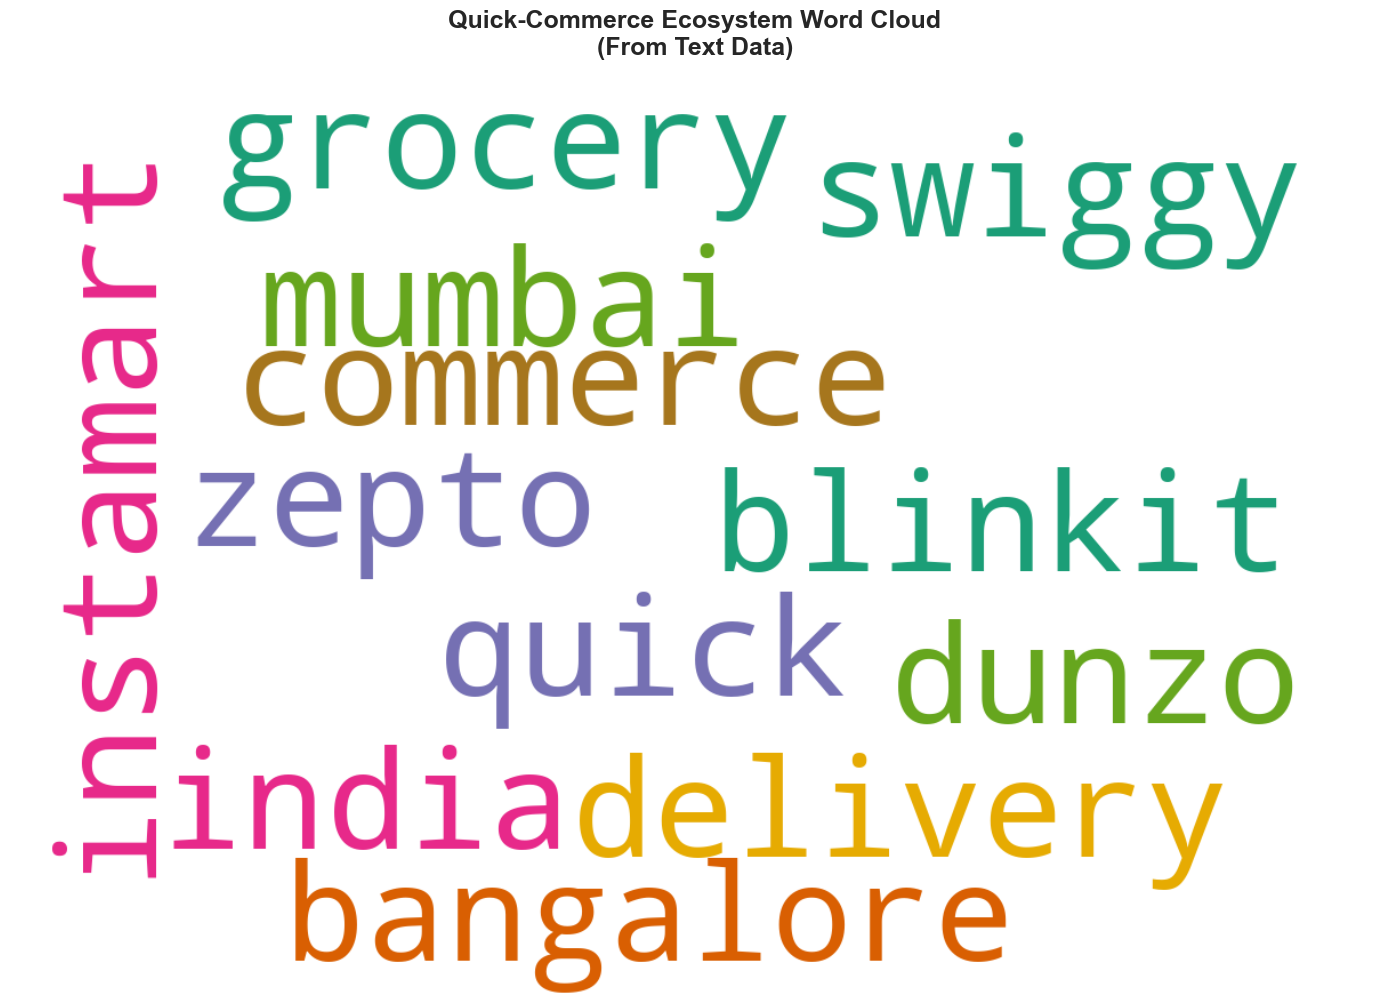

In [9]:
print("\n5/5: Sentiment Word Cloud")

# Extract only text columns
text_parts = []
for df_name, df in data.items():
    for col in df.columns:
        if df[col].dtype == 'object':  # Only string columns
            clean_col = df[col].astype(str).str.lower()
            # Remove nan, true, false, numbers
            clean_col = clean_col[~clean_col.str.contains('nan|true|false|^[0-9]+$', case=False, na=False, regex=True)]
            text_parts.extend(clean_col.dropna().tolist())

# Combine and clean
full_text = ' '.join(text_parts)
full_text = ' '.join([word for word in full_text.split() if len(word) > 2])  # Remove short junk

if len(full_text.strip()) == 0:
    full_text = "quick commerce swiggy dunzo blinkit zepto instamart delivery grocery india mumbai bangalore"

# Generate word cloud
wordcloud = WordCloud(
    width=1200, height=800,
    background_color='white',
    colormap='Dark2',
    max_words=100,
    min_font_size=10,
    max_font_size=120
).generate(full_text)

plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Quick-Commerce Ecosystem Word Cloud\n(From Text Data)', fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('../visualizations/05_sentiment_wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()